In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from itertools import product, combinations
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from dolfin import *

import multirat.base.projectors as projectors
from multirat.parameters import get_default_parameters
from multirat.base.timeseriesstorage import TimeSeriesStorage

# Multi-Compartment Model
In this notebook, I attempt to implement the full fledged multi-compartment model for solute transport within the rat brain. The implementation will be an attempt to convert Alexandre's implementation to a style similar to the diffusion implementation.

## Intentions
The goal of this notebook is to impose a bit more of a structure on the implementation of a model. The purpose of the structure is two-fold: Firstly, it will make it easier to implement convergence-studies for time- and mesh-resolutions. Secondly, the structure willl (hopefully) make the code more accessible, reproducable and extensible.

## Methods
* All implementations will initially be done using a 2D-square. Thereafter it will be extended to the ratbrain. 

### 1. Implement the multi-compartment pressure model
- [x] 
    * Start with only two compartments.
    * Use Dirichlet boundary conditions on arterial and venous compartment.
    * Store and visualize results using the new timeseriesstorage-class.
### 2. Implement a convetion-diffusion equation with a prescribed stationary velocity field
- [x] 
    * Still use only two compartments.
    * Fluid flow inwards in arterial compartment, outwards in venous.
    * Use Homogeneous boundary conditions.
    * Initial condition, non-centralized gaussian. 
### 3. Load velocity field from the pressure fields within each compartment, and use in transport equation.
- [x] 
    * Keep defaults from above.
### 4. Run a convergence study for both pressure field and solute transport
- [ ] 
    * Run a classical L2, H1-convergence on the pressure fields.
    * Compute and plot the clearance curves for varying mesh and time resolution.
### 5. Add more compartments (4-compartment model)
- [x] 
    * Create functionality to easily include new compartments.
    * Rerun convergence study with 4-compartment model. 
### 6. Adapt to ratbrain-mesh and proper parameters.
- [ ] 
    * Use proper mesh
    * Extract parameters from Alexandre's latest file.
    * Recreate the results from the current paper.
### 7. Refactor Solver

In [3]:
from multirat.base.meshprocessing import Domain
from typing import List

In [4]:
def create_mesh(n, x0=-1., y0=-1., x1=1., y1=1.):
    return Domain(
        mesh=RectangleMesh(Point(x0, y0), Point(x1, y1), n, n),
        subdomains=None,
        boundaries=None,
    )

domain = create_mesh(20)
domain.mesh;

parameters = ["porosity", "viscosity", "permeability"]#, "diffusion_inulin_free"]
compartments = ["pvs_arteries", "pvs_veins", "ecs"]#, "pvs_capillaries"]

P1 = FiniteElement('CG', domain.mesh.ufl_cell(), 1)
el = MixedElement([P1]* len(compartments))
V = FunctionSpace(domain.mesh, el)

### Define parameters

In [5]:
compartment_properties = {
    f"{parameter}-{comp}": 1. for parameter, comp in product(parameters, compartments)
}
diffusion_constant = {
    f"diffusion_inulin_free-{comp}": 0.01 for comp in compartments
}
fluid_transfer = {
    f"transfer_fluid-{comp1}-{comp2}": 1.0 for comp1, comp2 in combinations(compartments, 2)
}
diffusive_transfer = {
    f"transfer_solute_diffusive-{comp1}-{comp2}": 1.0 for comp1, comp2 in combinations(compartments, 2)
}
convective_transfer = {
    f"transfer_solute_convective-{comp1}-{comp2}": 1.0 for comp1, comp2 in combinations(compartments, 2)
}
params = {
    **compartment_properties,
    **diffusion_constant,
    **fluid_transfer,
    **diffusive_transfer,
    **convective_transfer,
}
params

{'porosity-pvs_arteries': 1.0,
 'porosity-pvs_veins': 1.0,
 'porosity-ecs': 1.0,
 'viscosity-pvs_arteries': 1.0,
 'viscosity-pvs_veins': 1.0,
 'viscosity-ecs': 1.0,
 'permeability-pvs_arteries': 1.0,
 'permeability-pvs_veins': 1.0,
 'permeability-ecs': 1.0,
 'diffusion_inulin_free-pvs_arteries': 0.01,
 'diffusion_inulin_free-pvs_veins': 0.01,
 'diffusion_inulin_free-ecs': 0.01,
 'transfer_fluid-pvs_arteries-pvs_veins': 1.0,
 'transfer_fluid-pvs_arteries-ecs': 1.0,
 'transfer_fluid-pvs_veins-ecs': 1.0,
 'transfer_solute_diffusive-pvs_arteries-pvs_veins': 1.0,
 'transfer_solute_diffusive-pvs_arteries-ecs': 1.0,
 'transfer_solute_diffusive-pvs_veins-ecs': 1.0,
 'transfer_solute_convective-pvs_arteries-pvs_veins': 1.0,
 'transfer_solute_convective-pvs_arteries-ecs': 1.0,
 'transfer_solute_convective-pvs_veins-ecs': 1.0}

In [9]:
def get_interface_parameter(
    name, comp1, comp2, parameters, symmetric
):
    try:
        return parameters[f"{name}-{comp1}-{comp2}"]
    except KeyError as e:
        if symmetric:
            return parameters[f"{name}-{comp2}-{comp1}"]
        else:
            raise ValueError(e)
            

def get_transfer_coefficients(name, parameters, compartments, symmetric=True):
    """Extract fluid transfer coeffients from parameter-dictionary,
    between all compartments listed in the compartments. Assumes
    symmetric coefficients and adds transfer coefficients for
    both i->j and j->i
    """
    T = {
    (i, j): get_interface_parameter(name, i, j, parameters, symmetric)
        for (i, j) in combinations(compartments, 2)
    }
    return {
        **T,
        **{
            (j, i): get_interface_parameter(name, j, i, parameters, symmetric)
                for (i, j) in combinations(compartments, 2)
        }
    }

            
def darcy_constant(permeability, viscosity, porosity):
    return permeability / (viscosity * porosity)


def compute_darcy_constants(p, compartments):
    return {
        x:
            darcy_constant(
                p[f"permeability-{x}"],
                p[f"viscosity-{x}"],
                p[f"porosity-{x}"]
            )
        for x in compartments
    }

def pressure_variational_form(p: Function, compartments: List[str], parameters):
    if not V.num_sub_spaces() == len(compartments):
        raise ValueError("V should be MixedElement space of same dimension as the number of compartments.")
    
    q = TestFunctions(p.function_space())
    k = {key: Constant(val) for key, val in compute_darcy_constants(parameters, compartments).items()}
    T = {key: Constant(val) for key, val in get_transfer_coefficients("transfer_fluid", parameters, compartments).items()}
    a = 0.
    for j, comp_j in enumerate(compartments):
        a += (
            k[comp_j] * inner(grad(p[j]), grad(q[j])) 
            - sum([ T[(comp_i, comp_j)]*(p[i] - p[j])*q[j] for i, comp_i in enumerate(compartments) if i != j])
        ) * dx
    return a, None

def item_to_idx(list_):
    return {
        item: idx for idx, item in enumerate(list_)
    }

def to_xdmf(path, names):
    visual = TimeSeriesStorage("r", path)
    visual.to_xdmf(names)
    visual.close()
    
    
def compute_vectorfields(p: Function):
    V = p.function_space()
    mesh = V.mesh()
    degree = V.ufl_element().degree()
    W = VectorFunctionSpace(mesh, "P", degree)
    return [project(grad(pi), W) for pi in p]

In [10]:
def solve_multicomartment_pressure(V, domain, compartments, boundaries, results_path, parameters):
    P = Function(V)
    a, _ = pressure_variational_form(P, compartments, parameters)
    solve(a == Constant(0.), P, bcs=boundaries) # TODO: Move over to process-boundary function.

    results_path = Path(results_path)
    
    # TODO: Create a storage class for stationary problems
    storage = TimeSeriesStorage("w", results_path, V=V, mesh=domain.mesh)
    storage.write(P, 0.)
    storage.close()
    to_xdmf(storage.filepath, compartments)
    return P

Calling FFC just-in-time (JIT) compiler, this may take some time.
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 3.486e+01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 2.439e-14 (tol = 1.000e-10) r (rel) = 6.998e-16 (tol = 1.000e-09)
  Newton solver finished in 1 iterations and 1 linear solver iterations.
Object cannot be plotted directly, projecting to piecewise linears.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


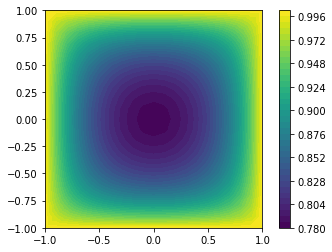

Calling FFC just-in-time (JIT) compiler, this may take some time.
Object cannot be plotted directly, projecting to piecewise linears.


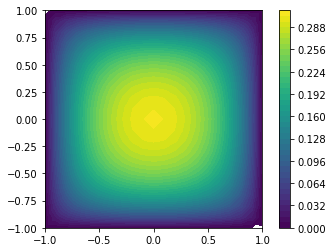

Calling FFC just-in-time (JIT) compiler, this may take some time.
Object cannot be plotted directly, projecting to piecewise linears.


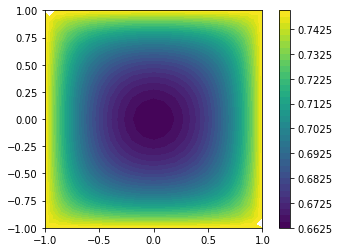

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Object cannot be plotted directly, projecting to piecewise linears.
Calling FFC just-in-time (JIT) compiler, this may take some time.


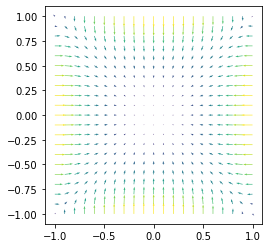

Object cannot be plotted directly, projecting to piecewise linears.


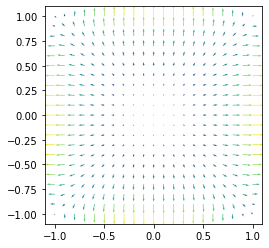

Object cannot be plotted directly, projecting to piecewise linears.


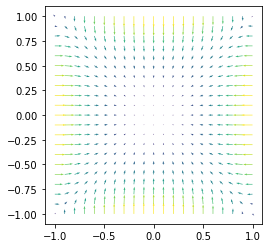

In [11]:
P1 = FiniteElement('CG', domain.mesh.ufl_cell(), 1)
el = MixedElement([P1]* len(compartments))
V = FunctionSpace(domain.mesh, el)

compartment_idx_map = item_to_idx(compartments)
bcs = [
    DirichletBC(V.sub(compartment_idx_map["pvs_arteries"]), Constant(1.), "on_boundary"),
    DirichletBC(V.sub(compartment_idx_map["pvs_veins"]), Constant(0.), "on_boundary"),
    DirichletBC(V.sub(compartment_idx_map["ecs"]), Constant(0.75), "on_boundary"),
#     DirichletBC(V.sub(compartment_idx_map["pvs_capillaries"]), Constant(0.25), "on_boundary"),
]

P = solve_multicomartment_pressure(V, domain, compartments, bcs, "../results/multicompratment-testing/", params)
for pi in P:
    c = plot(pi)
    plt.colorbar(c)
    plt.show()

u = compute_vectorfields(P)

for ui in u:
    plot(-ui)
    plt.show()

In [9]:
def compute_non_porous_darcy_constants(p, compartments):
    return {
        i:
            darcy_constant(
                p[f"permeability-{x}"],
                p[f"viscosity-{x}"],
                1.
            )
        for i, x in enumerate(compartments)
    }

def get_porosities(p, compartments):
    return {
        i:
            p[f"porosity-{x}"]
        for i, x in enumerate(compartments)
    }

def get_diffusion_constants(p, compartments):
    return {
        i:
            p[f"diffusion_inulin_free-{x}"]
        for i, x in enumerate(compartments)
    }

In [12]:
def solute_variational_form(V: FunctionSpace, c0: Function, p: Function, compartments: List[str], parameters, dt):
    c = TrialFunction(V)
    v = TestFunction(V)
    
    J = len(compartments)
    k = {
        key: Constant(val) for key, val in compute_non_porous_darcy_constants(parameters, compartments).items()}
    phi = {
        key: Constant(val) for key, val in get_porosities(parameters, compartments).items()
    }
    D = {
        key: Constant(val) for key, val in get_diffusion_constants(parameters, compartments).items()
    }
    
    
    L = {
        key: Constant(val) for key, val in get_transfer_coefficients(
                                                "transfer_solute_diffusive",
                                                parameters,
                                                compartments
                                            ).items()
    }
    G = {
        key: Constant(val) for key, val in get_transfer_coefficients(
                                                "transfer_solute_convective",
                                                parameters,
                                                compartments
                                            ).items()
    }
    a = 0.
    l = 0.
#     n = FacetNormal(V.mesh())
    
    # TODO: Tidy up everything
    for j in range(J):
        a += (
            c[j] * v[j]
            + dt * inner(D[j] * grad(c[j]) + 2.* k[j] * c[j] * grad(p[j]), grad(v[j]))
            - (dt / phi[j]) * v[j] * sum([
                L[(i, j)]*(c[i] - c[j])
                + 0.5 * G[(i, j)] * (c[i] + c[j]) * (p[i] - p[j])
            for i in range(J) if i != j ])) * dx
        l += c0[j] * v[j] * dx
    return a, l

Object cannot be plotted directly, projecting to piecewise linears.


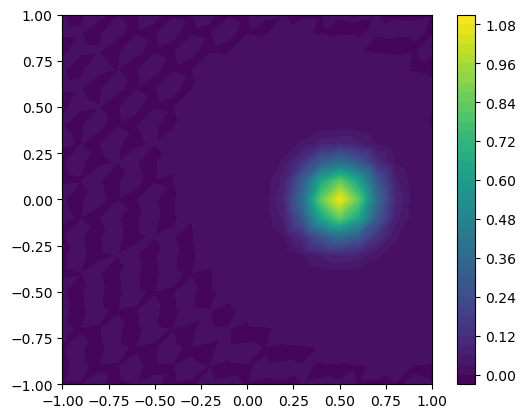

Object cannot be plotted directly, projecting to piecewise linears.


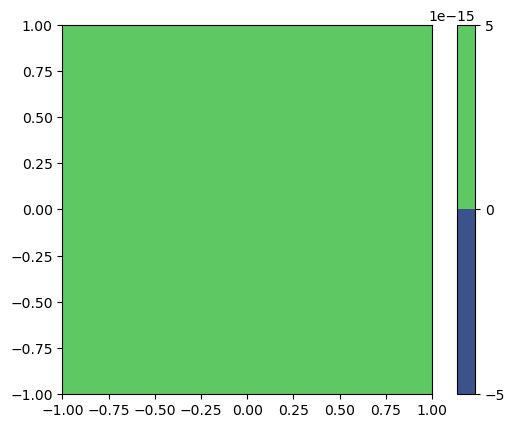

Object cannot be plotted directly, projecting to piecewise linears.


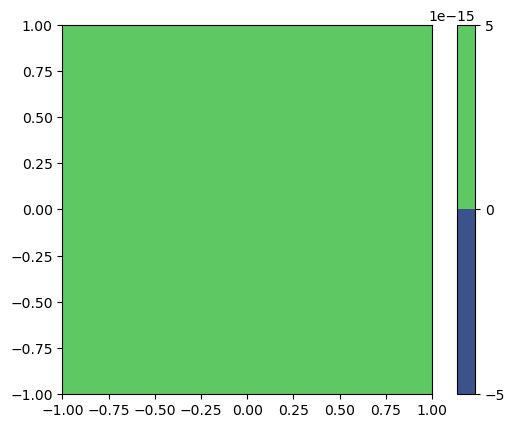

Solving linear variational problem.
Object cannot be plotted directly, projecting to piecewise linears.


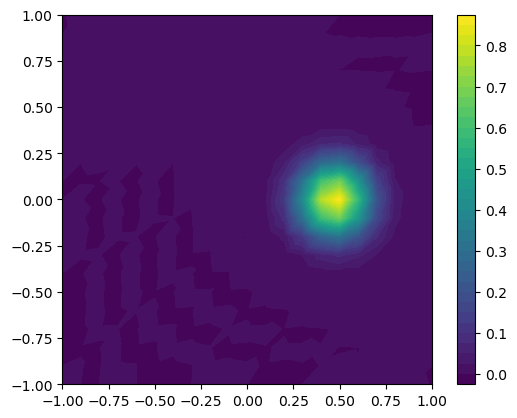

Object cannot be plotted directly, projecting to piecewise linears.


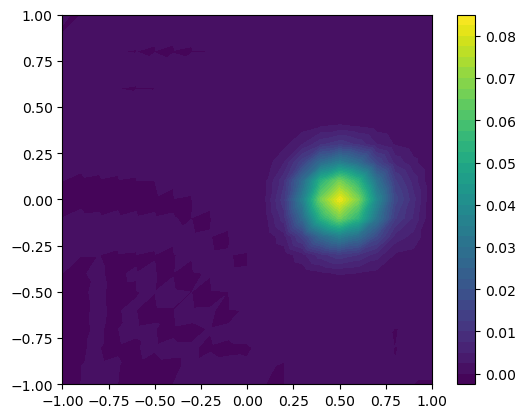

Object cannot be plotted directly, projecting to piecewise linears.


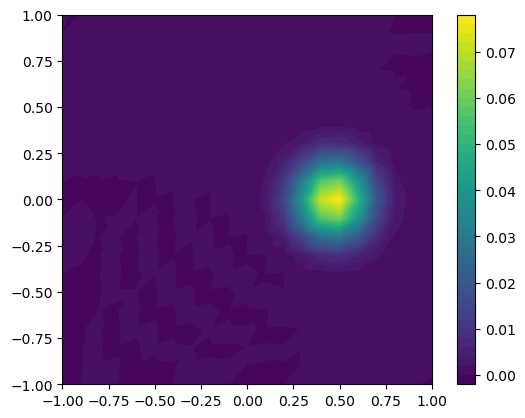

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Object cannot be plotted directly, projecting to piecewise linears.


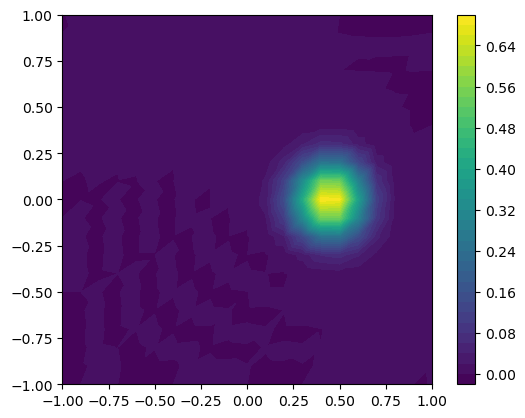

Object cannot be plotted directly, projecting to piecewise linears.


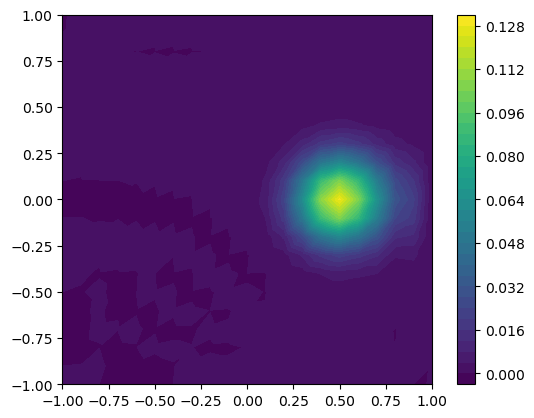

Object cannot be plotted directly, projecting to piecewise linears.


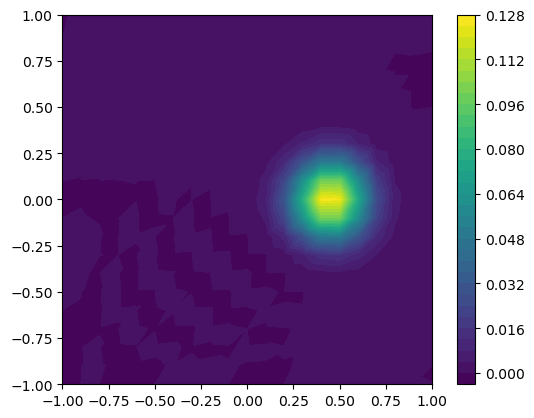

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Object cannot be plotted directly, projecting to piecewise linears.


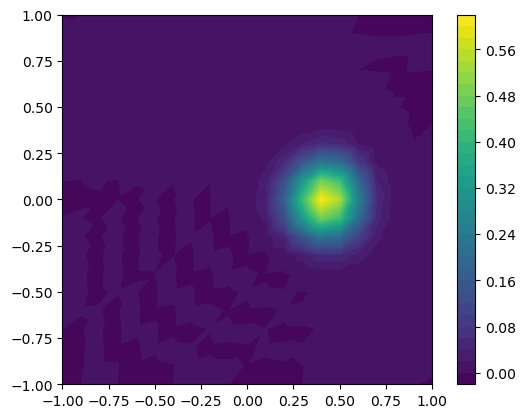

Object cannot be plotted directly, projecting to piecewise linears.


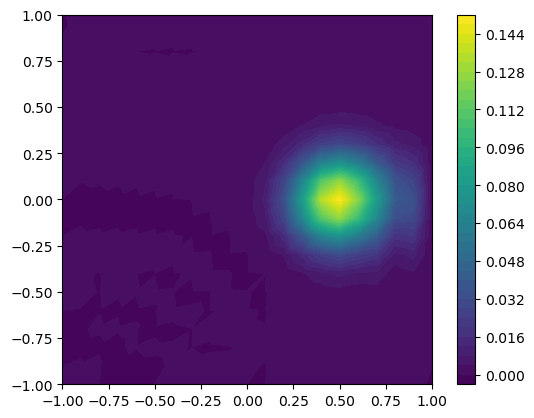

Object cannot be plotted directly, projecting to piecewise linears.


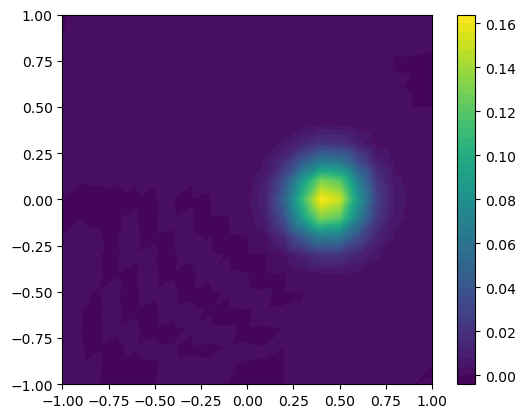

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Object cannot be plotted directly, projecting to piecewise linears.


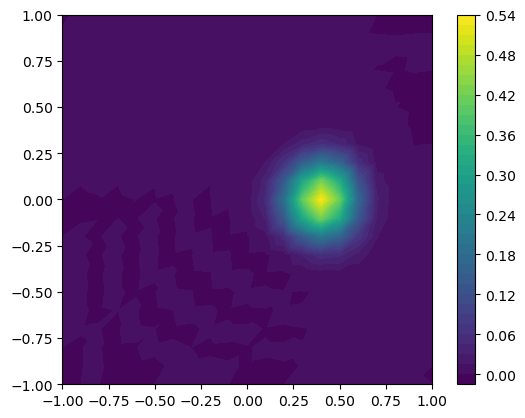

Object cannot be plotted directly, projecting to piecewise linears.


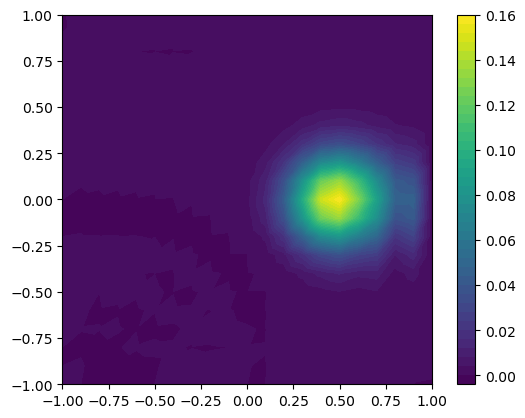

Object cannot be plotted directly, projecting to piecewise linears.


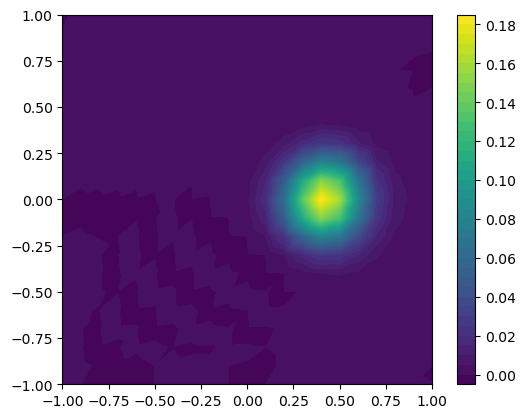

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Object cannot be plotted directly, projecting to piecewise linears.


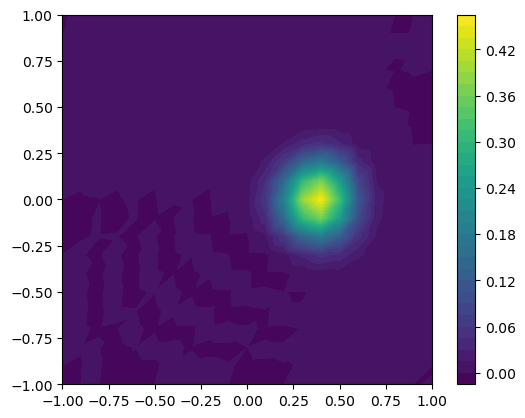

Object cannot be plotted directly, projecting to piecewise linears.


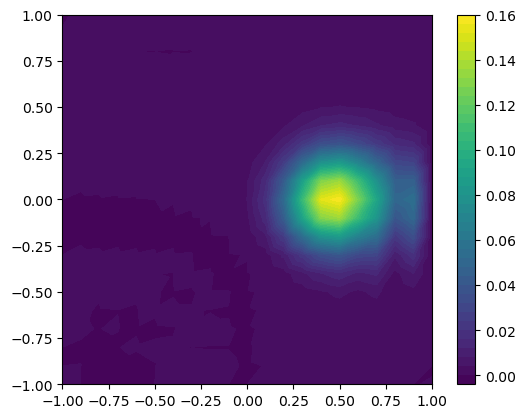

Object cannot be plotted directly, projecting to piecewise linears.


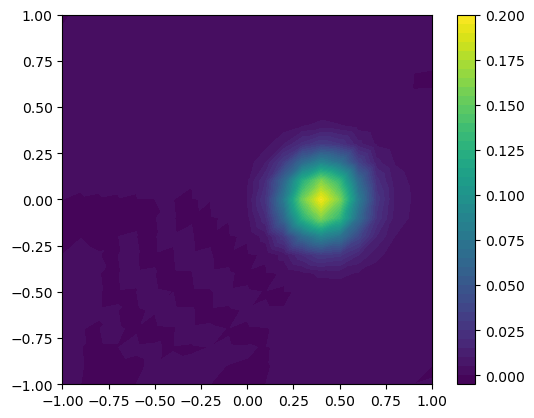

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Object cannot be plotted directly, projecting to piecewise linears.


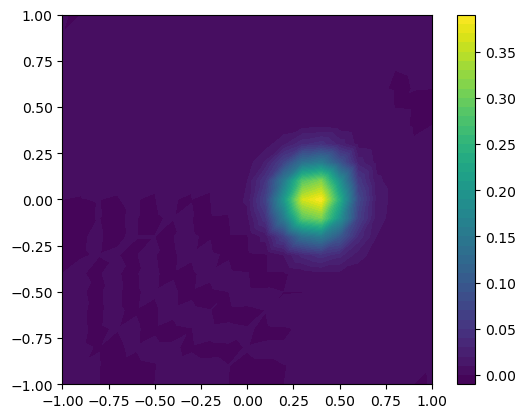

Object cannot be plotted directly, projecting to piecewise linears.


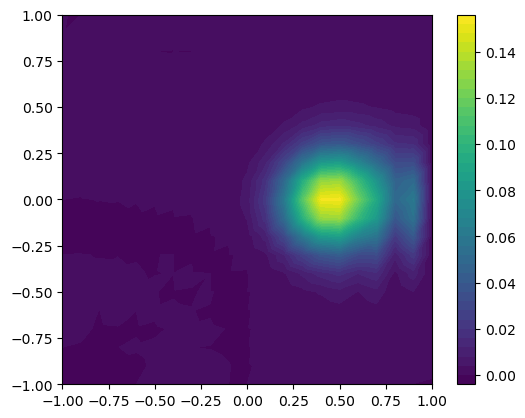

Object cannot be plotted directly, projecting to piecewise linears.


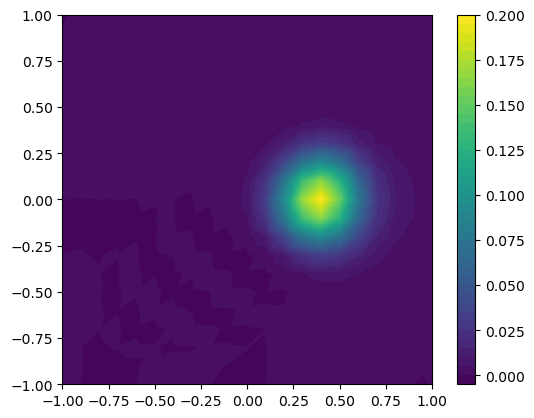

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Object cannot be plotted directly, projecting to piecewise linears.


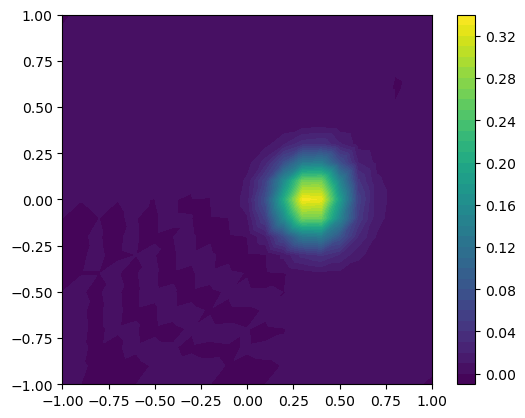

Object cannot be plotted directly, projecting to piecewise linears.


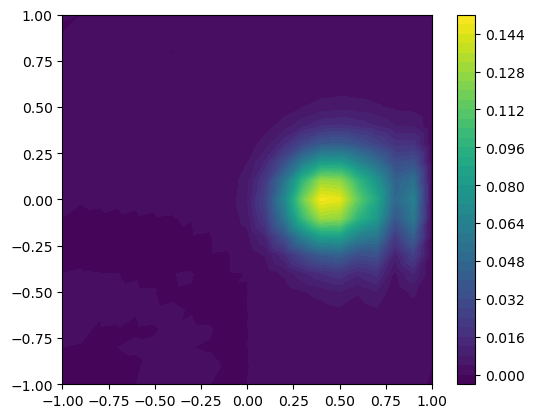

Object cannot be plotted directly, projecting to piecewise linears.


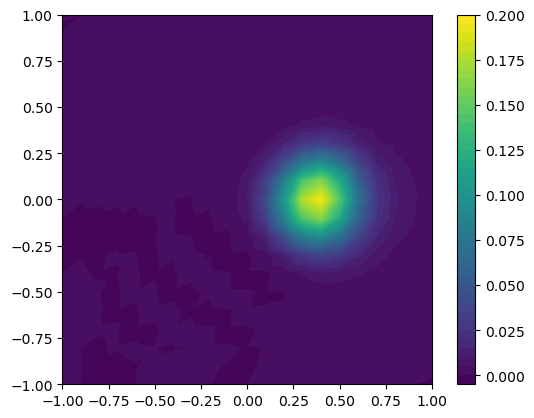

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Object cannot be plotted directly, projecting to piecewise linears.


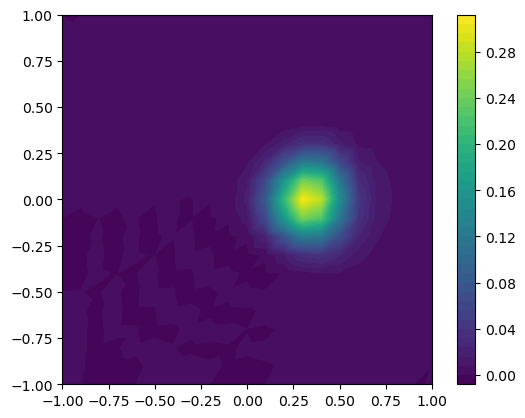

Object cannot be plotted directly, projecting to piecewise linears.


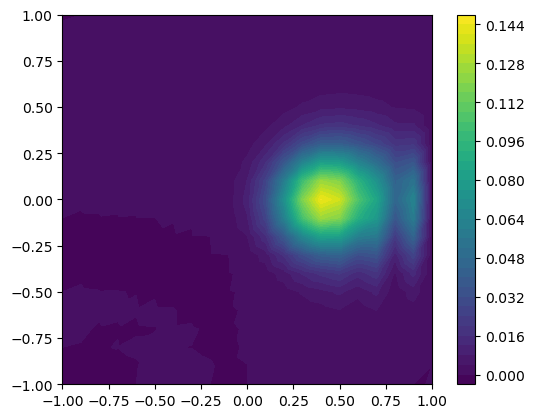

Object cannot be plotted directly, projecting to piecewise linears.


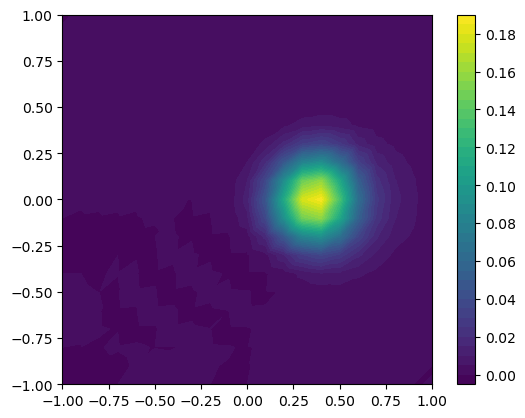

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Object cannot be plotted directly, projecting to piecewise linears.


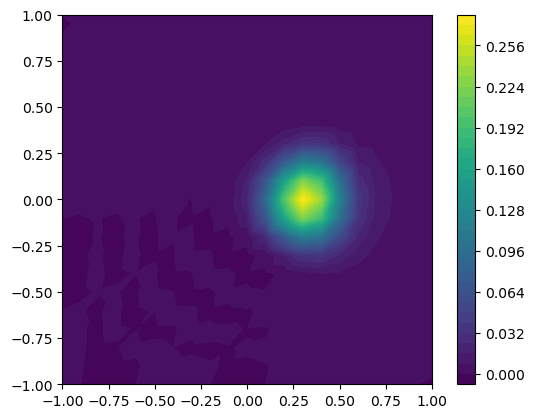

Object cannot be plotted directly, projecting to piecewise linears.


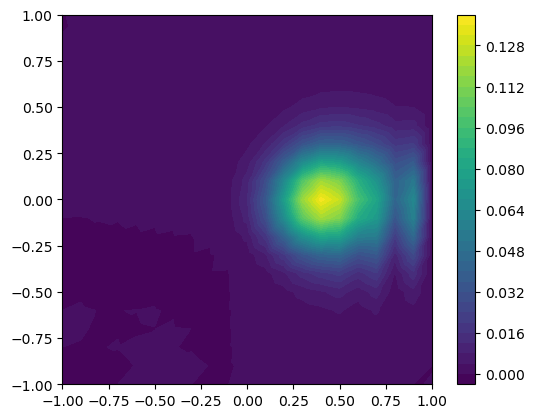

Object cannot be plotted directly, projecting to piecewise linears.


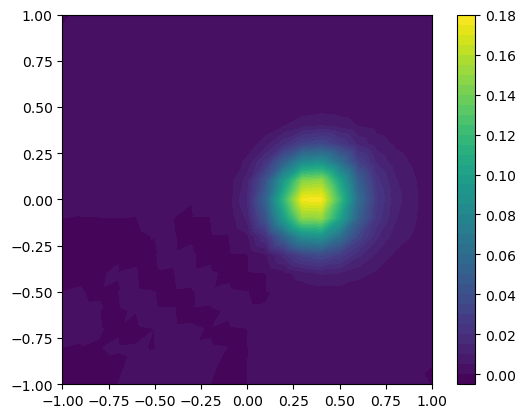

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Object cannot be plotted directly, projecting to piecewise linears.


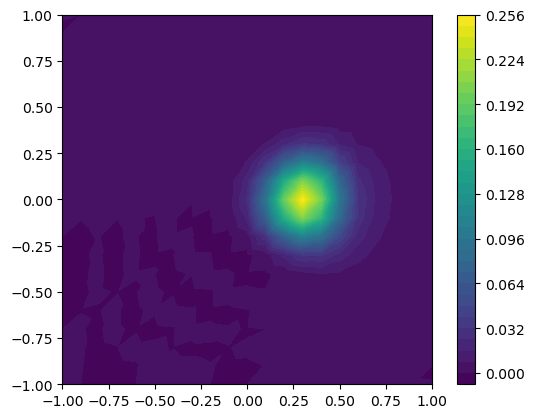

Object cannot be plotted directly, projecting to piecewise linears.


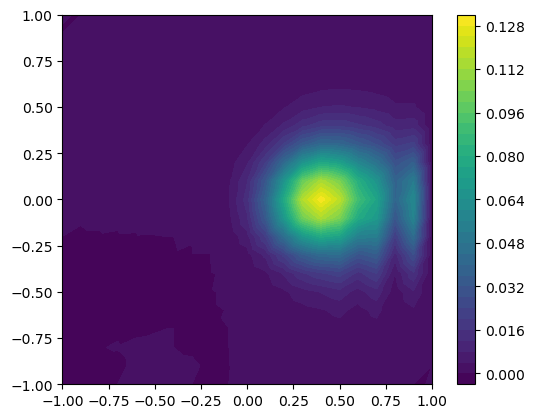

Object cannot be plotted directly, projecting to piecewise linears.


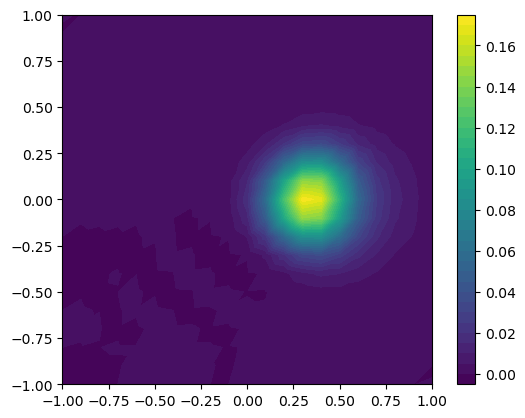

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Object cannot be plotted directly, projecting to piecewise linears.


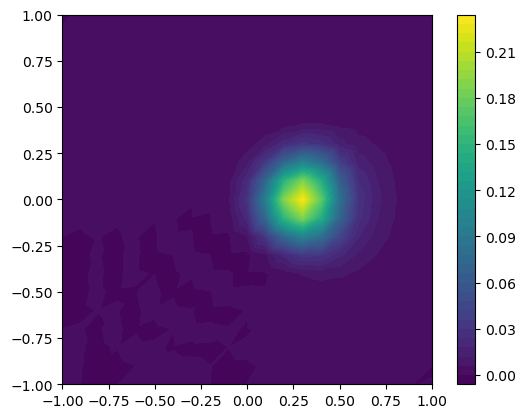

Object cannot be plotted directly, projecting to piecewise linears.


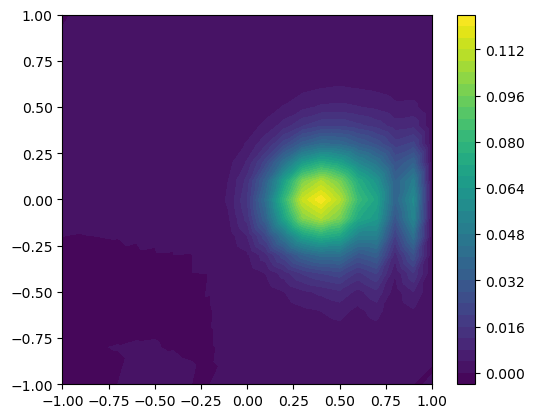

Object cannot be plotted directly, projecting to piecewise linears.


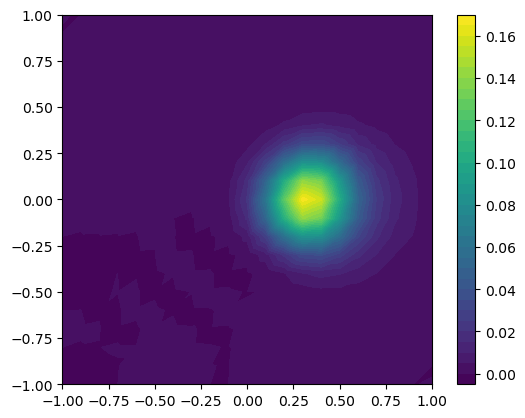

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Object cannot be plotted directly, projecting to piecewise linears.


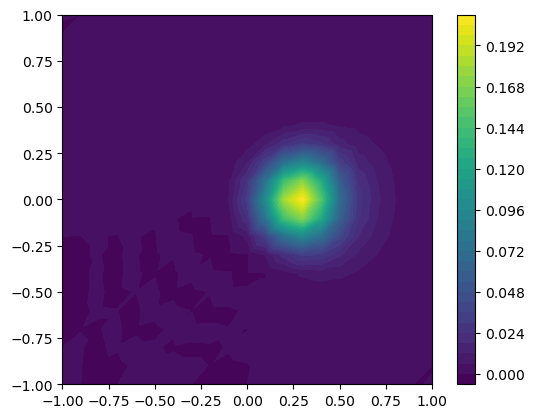

Object cannot be plotted directly, projecting to piecewise linears.


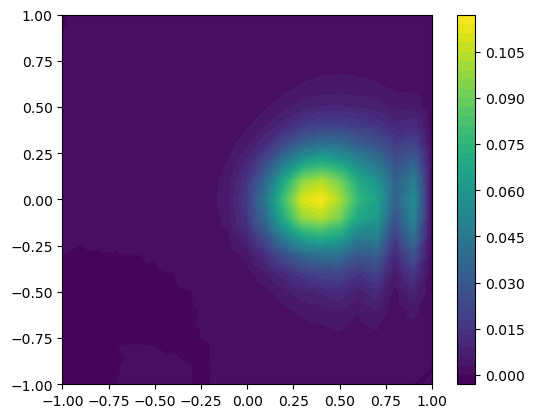

Object cannot be plotted directly, projecting to piecewise linears.


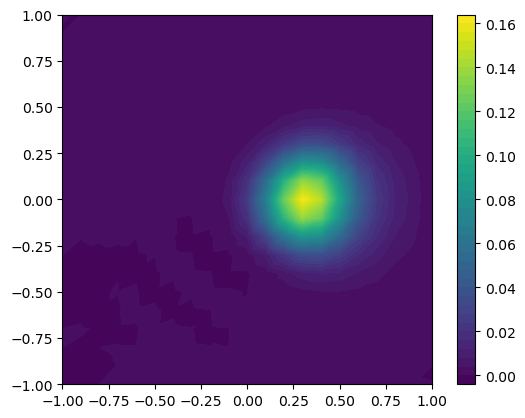

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Object cannot be plotted directly, projecting to piecewise linears.


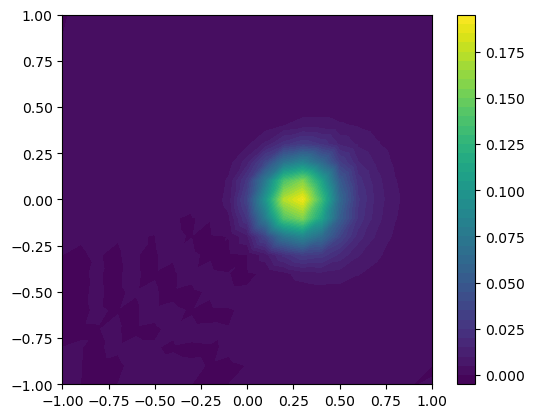

Object cannot be plotted directly, projecting to piecewise linears.


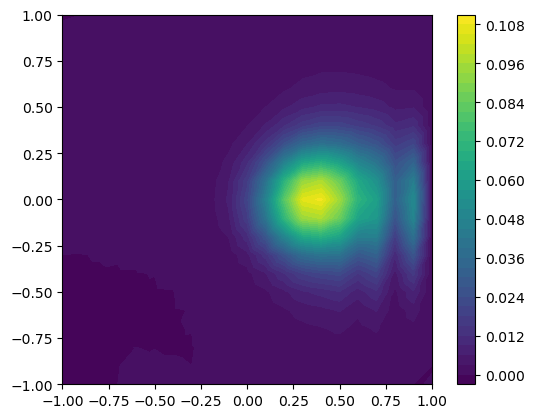

Object cannot be plotted directly, projecting to piecewise linears.


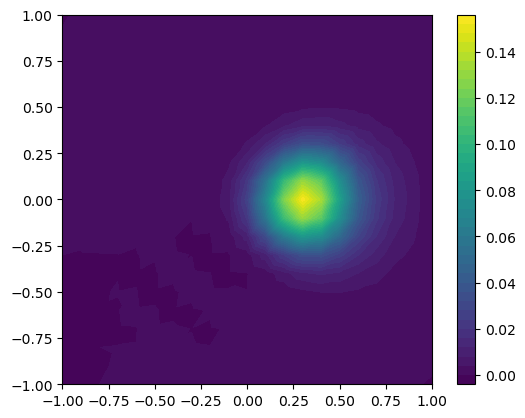

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Object cannot be plotted directly, projecting to piecewise linears.


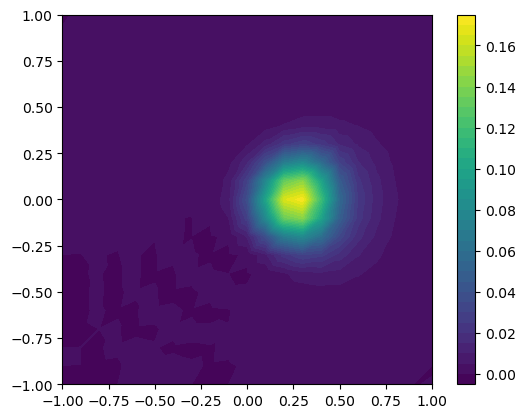

Object cannot be plotted directly, projecting to piecewise linears.


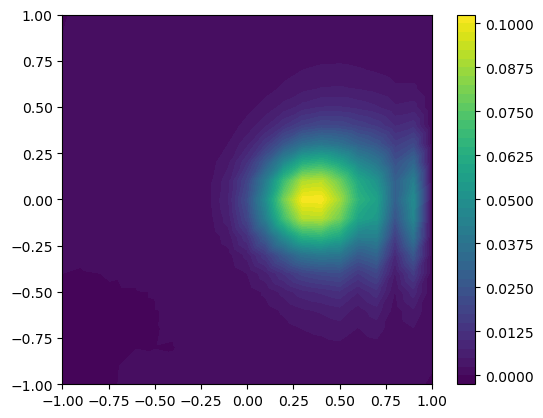

Object cannot be plotted directly, projecting to piecewise linears.


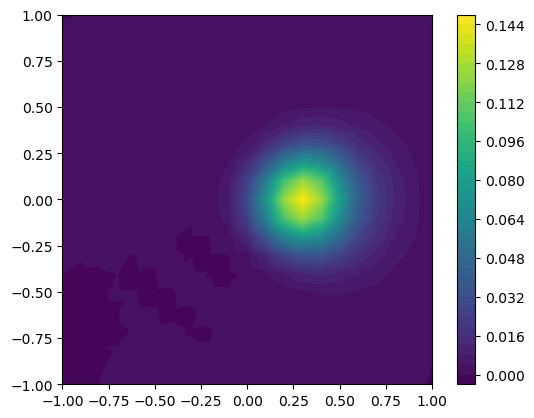

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Object cannot be plotted directly, projecting to piecewise linears.


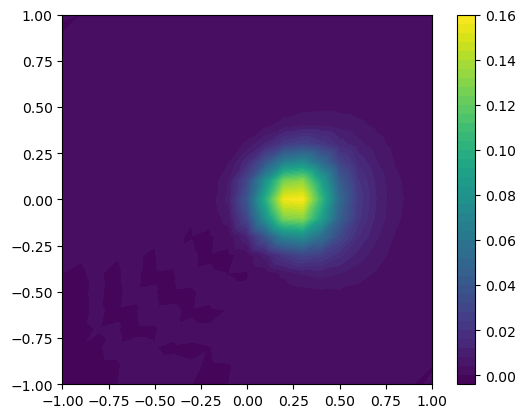

Object cannot be plotted directly, projecting to piecewise linears.


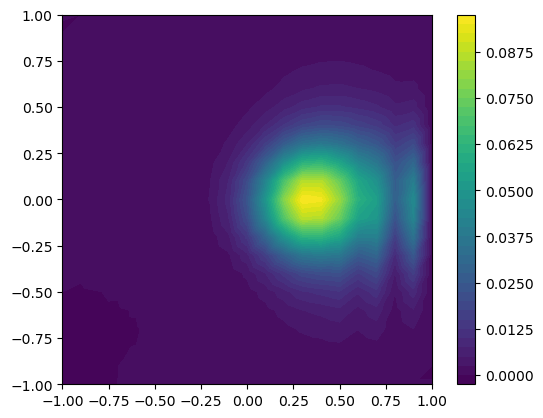

Object cannot be plotted directly, projecting to piecewise linears.


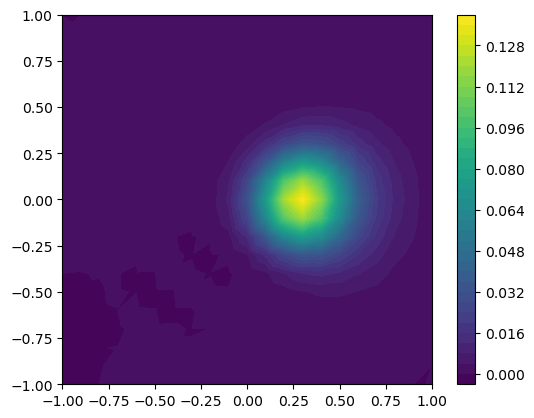

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Object cannot be plotted directly, projecting to piecewise linears.


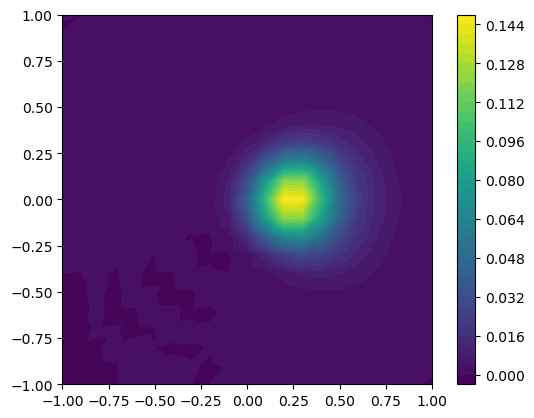

Object cannot be plotted directly, projecting to piecewise linears.


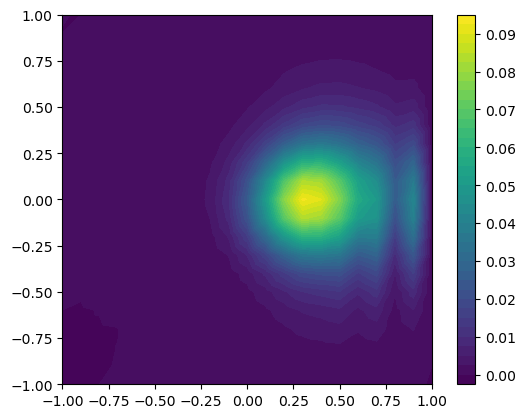

Object cannot be plotted directly, projecting to piecewise linears.


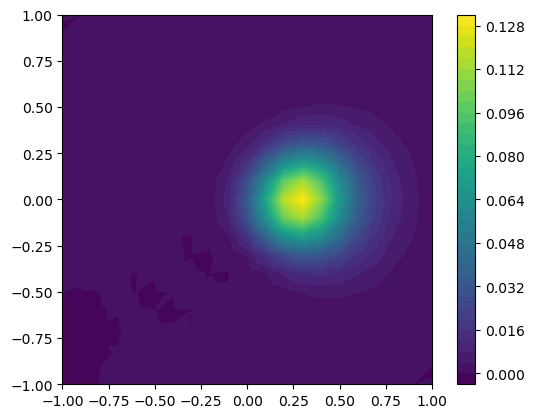

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Object cannot be plotted directly, projecting to piecewise linears.


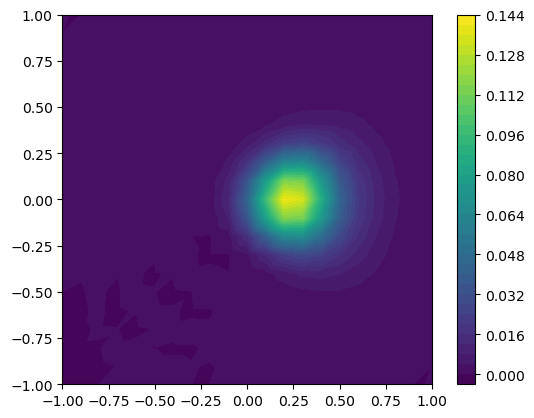

Object cannot be plotted directly, projecting to piecewise linears.


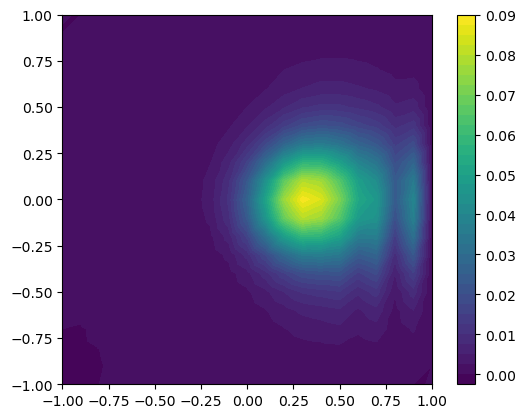

Object cannot be plotted directly, projecting to piecewise linears.


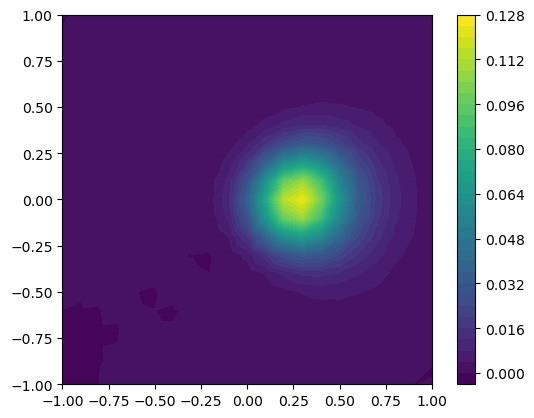

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Object cannot be plotted directly, projecting to piecewise linears.


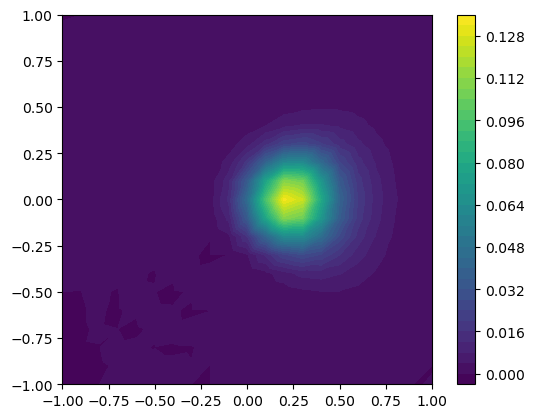

Object cannot be plotted directly, projecting to piecewise linears.


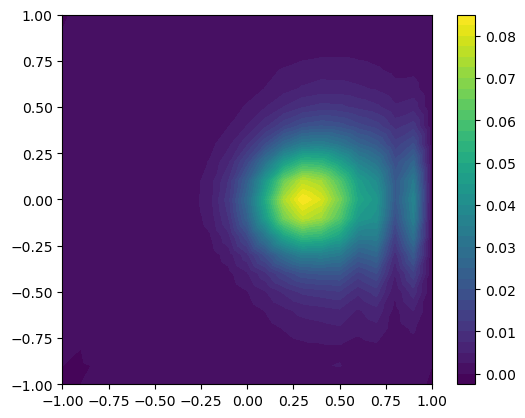

Object cannot be plotted directly, projecting to piecewise linears.


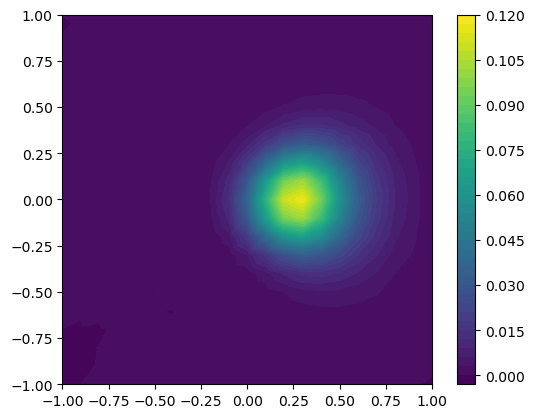

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Object cannot be plotted directly, projecting to piecewise linears.


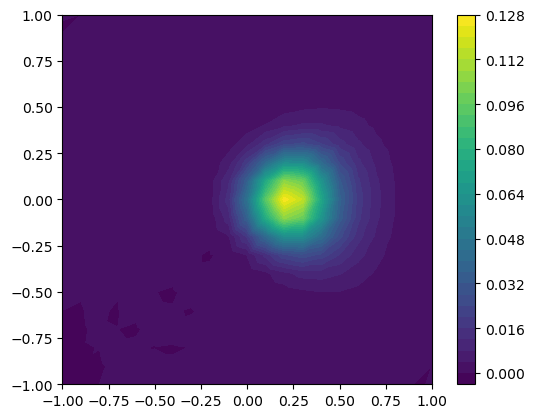

Object cannot be plotted directly, projecting to piecewise linears.


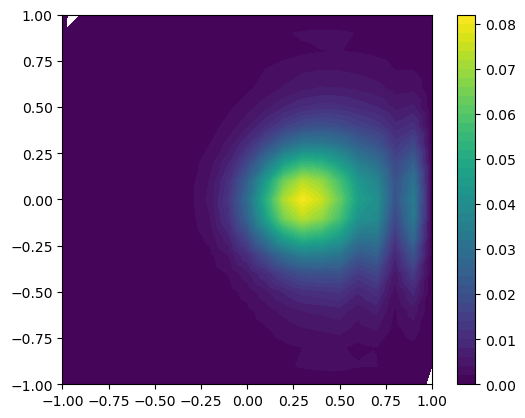

Object cannot be plotted directly, projecting to piecewise linears.


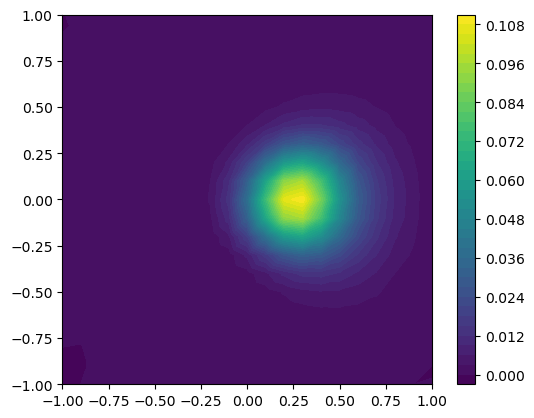

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Object cannot be plotted directly, projecting to piecewise linears.


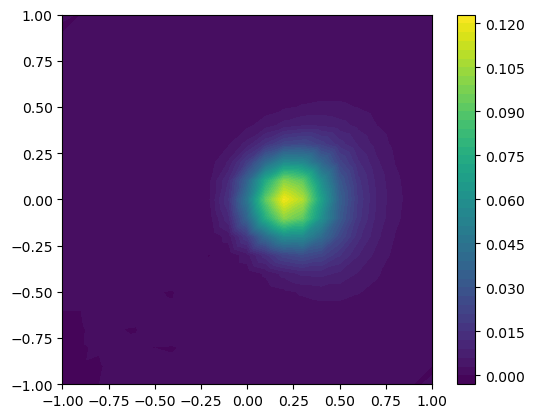

Object cannot be plotted directly, projecting to piecewise linears.


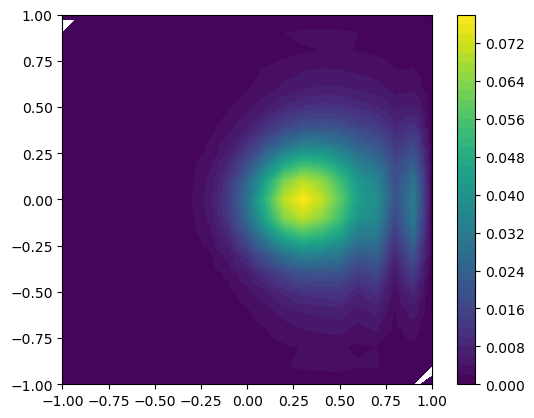

Object cannot be plotted directly, projecting to piecewise linears.


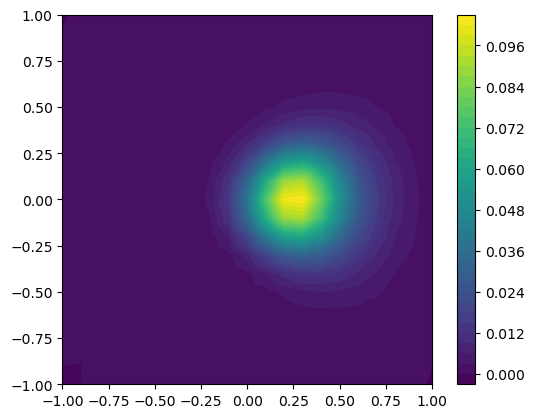

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


In [16]:
c_init = Expression("exp(-(pow(x[0] - c[0], 2) + pow(x[1]-c[1], 2)) / (length * length))",
                    length=Constant(0.2), c=Constant((0.5, 0.0)), degree=2)

c0 = Function(V)
assign(c0.sub(0), project(c_init, V.sub(0).collapse()))
for c0i in c0:
    c = plot(c0i)
    plt.colorbar(c)
    plt.show()

a, l = solute_variational_form(V, c0, P, compartments, params, 0.1)

bcs = []
bcs = [
    DirichletBC(V.sub(compartment_idx_map["pvs_arteries"]), Constant(0.), "on_boundary"),
    DirichletBC(V.sub(compartment_idx_map["pvs_veins"]), Constant(0.), "on_boundary"),
    DirichletBC(V.sub(compartment_idx_map["ecs"]), Constant(0.), "on_boundary"),
]

c = Function(V)


for i in range(100):
    solve(a == l, c, bcs=bcs)
    if i % 5 == 0:
        print("======")
        for ci in c:
            col = plot(ci)#, vmin=0, vmax=1)
            plt.colorbar(col)
            plt.show()
        c0.assign(c)

## Graveyard